In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# Notes / Todo

- Implement Kalman half of SDN
- Implement Kalman half of vanilla 
- Debug SDN solution


# LQR 

### Parameters  

Finite-Horizon Dynamics

$x_{t+1} = A_tx_t + B_tu_t$ 

$t \in \{0,...,T\}$

Cost to minimize

$J_{T}(u) = \sum_{t=0}^{N-1}{x_t^TQ_tx_t + u_t^TR_tu_t + x_T^TQ_Tx_T}$

Control Law

$u_t^*(x) = -L_tx$

$L_t = -(R_t+B^TS_{t+1}B)^{-1}(B^TS_{t+1}A)x$

Optimal Cost-to-Go Solution

$S_t = A^TS_{t+1}A - (A^TS_{t+1}B)(R + B^TS_{t+1}B)^{-1}(B^TS_{t+1}A) + Q_t$

$S_T = Q_T$


In [2]:
dt = 0.010 # sec 
T = 5 # sec
times = np.linspace(0,T,T/dt)

# hyperparams 
tau = 0.040 # 40ms, exponential filter constant 
m = 1
r = 0.002
noise_mag = .001
wv = 0.01
wf = 0.001

# path 
targets = [
    (5,5,1*len(times)//5),
    (10,5,2*len(times)//5),
    (10,10,3*len(times)//5),
    (5,10,4*len(times)//5)
]
endpoint = [0,0]

# initial conditions 
px0 = 0.1
py0 = 0.1
vx0 = 0.1
vy0 = 0.1 
fx0 = 0.0
fy0 = 0.0
x = np.array([px0, py0, vx0, vy0, fx0, fy0, 1]).reshape(-1,1)

# dynamics 
A = np.eye(x.shape[0])
A[0][2] = dt 
A[1][3] = dt 
A[2][4] = dt/m
A[3][5] = dt/m
A[4][4] = np.exp(-dt/tau)
A[5][5] = np.exp(-dt/tau)

# dynamics noise 
Omega = np.eye(x.shape[0])
def sample_state_noise(x):
    return noise_mag*np.random.multivariate_normal(np.zeros(x.shape[0]),Omega).reshape(-1,1)

## task error
# via points 
D_targets = [np.array([
            [-1,  0, 0, 0, 0, 0, target[0]],\
            [0, -1, 0, 0, 0, 0, target[1]]])\
          for target in targets\
         ]
# end point 
D_end = np.array([
    [-1, 0, 0,  0,  0,  0,  endpoint[0]],\
    [0, -1, 0,  0,  0,  0,  endpoint[1]],\
    [0,  0, wv, 0,  0,  0,  0],\
    [0,  0, 0,  wv, 0,  0,  0],\
    [0,  0, 0,  0,  wf, 0,  0],\
    [0,  0, 0,  0,  0,  wf, 0],\
])
Q_list = []
ttimes = [t[2] for t in targets]
for i,t in enumerate(times):
    # add constraints to list of zero matrices 
    if i == len(times)-1: 
        Q_list.append((1/(len(D_targets)+1))*(D_end.T@D_end))
    elif np.any(i in ttimes):
        t_index = np.where(ttimes == i*np.ones(len(ttimes)))[0][0]
        # (add targets at specified times)
        Q_list.append((1/(len(D_targets)+1))*(D_targets[t_index].T@D_targets[t_index]))
    else:
        Q_list.append(np.zeros((x.shape[0],x.shape[0])))
# control acts on force
# dynamic 
B = np.array(\
    [[0,0],\
     [0,0],\
     [0,0],\
     [0,0],\
     [1,0],\
     [0,1],\
     [0,0]])
# cost 
R = r*np.eye(2)/len(times)

def backward_recurse(A,B,R,Q,S): 
    return A.T@S@A - (A.T@S@B)@np.linalg.inv(R + B.T@S@B)@(B.T@S@A) + Q

def compute_law(A,B,R,Q,S):
    return -np.linalg.inv(R + B.T@S@B)@(B.T@S@A)

/Users/spencerw/miniconda3/envs/bmi/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
# compute control law
Q = Q_list[-1]
S = Q_list[-1]
S_list = [S]
L_list = []
for Q in Q_list[-2::-1]: # no control at last time 
    L = compute_law(A,B,R,Q,S)
    S = backward_recurse(A,B,R,Q,S)
    S_list.append(S)
    L_list.append(L)
L_list = L_list[::-1]
S_list = S_list[::-1]
print(f"{len(S_list)} timesteps | {len(L_list)} control inputs")

# main loop 
x_list = [x]
u_list = []
for i,t in enumerate(times):
    if i != len(times)-1:
        # compute control
        u = L_list[i]@x
        u_list.append(u)
    # run dynamic
    x = A@x + B@u + sample_state_noise(x)
    x_list.append(x.reshape(-1,1))


500 timesteps | 499 control inputs


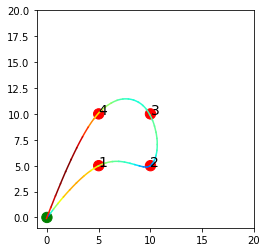

In [4]:
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.axis('square')
lim = 20
ax.set_xlim(-1,lim)
ax.set_ylim(-1,lim)
posx = [x[0] for x in x_list]
posy = [x[1] for x in x_list]
vel_mag = [np.sqrt(x[2]**2+x[3]**2)[0] for x in x_list]

steps=10
c = np.asarray(vel_mag)
c -= np.min(c)
c = c/np.max(c)
it=0
while it<c.size-steps:
    x_segm = posx[it:it+steps+1]
    y_segm = posy[it:it+steps+1]
    c_segm = plt.cm.jet( c[it+steps//2] )
    ax.plot(x_segm, y_segm, c=c_segm)
    it += steps


for i, target in enumerate(targets):
    ax.add_artist(plt.Circle((target[0],target[1]),0.5,color='r'))
    ax.add_artist(plt.Text(target[0],target[1],str(i+1),FontSize=14))
ax.add_artist(plt.Circle((endpoint[0],endpoint[1]),0.5,color='g'))

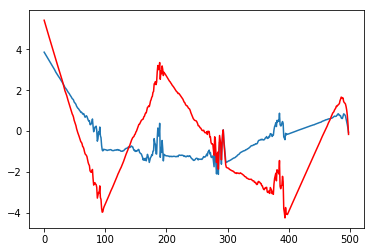

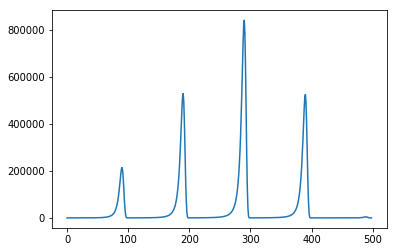

In [6]:
plt.figure()
plt.plot([u[0] for u in u_list])
plt.plot([u[1] for u in u_list],'r')
plt.figure()
L_eigs = []
for L in L_list:
    L_eigs.append(np.linalg.eig(L.T@L)[0][0])
plt.plot(L_eigs)

## LQG + SDN

We want to compare the vanilla noise setup to Todorov's signal-dependent noise LQG solution to understand the if this noise model change adjust the control law in an appreciable way. 

### Setup

Dynamics 

$x_{t+1} = Ax_t + Bu_t + \sum_{t=0}^T{C_t}u_t\xi_t$

Observations

$y_t = Hx_t + \omega_t$

Cost

$\sum_{t=0}^T{x_t^TQ_tx_t + u_t^TRu_t}$

Here we assume full state observation such that $H = \mathbb{I}^n$, thus the Kalman Filtering is irrelevant. The full system of equations for the solution to the above problem is 

Estimation 

$\hat{x}_{t+1} = A\hat{x}_t + Bu_t + K_t(y_t - H\hat{x}_t)$

$K_t = A\Sigma_t^eH^T(H\Sigma_t^eH^T + \Omega^\omega)^{-1}$

$\Sigma_{t+1}^x =KH\Sigma_t^eA^T + (A−BL_t)\Sigma_t^x(A−BL_t)$

$\Sigma_0^x =x_0x_0^T$

Control 

$u_t = -L_t\hat{x}_t$

$L_t = (B^TS_{t+1}^xB + R + \sum_n{C_n^T(S_{t+1}^x+S_{t+1}^e)C_n})^{-1}B^TS_{t+1}^xA$

$S_t^x = Q_t + A^TS_{t+1}^x(A-BL_t)$

$S_T^e = Q_T$

$S_t^e = A^TS_{t+1}^xBL_t + (A-K_tH)S_{t+1}^e(A-K_tH)$

$S_T^e = 0$

but in this simplified case, we let $K_t=AH^{-1}$ and $\omega=0$ to yield an altered set of control equations which are independent of $K_t$: 

$u_t = -L_t\hat{x}_t$

$L_t = (R + B^TS_{t+1}^xB + \sum_n{C_n^T(S_{t+1}^x+S_{t+1}^e)C_n})^{-1}B^TS_{t+1}^xA$

$S_t^x = Q_t + A^TS_{t+1}^x(A-BL_t)$

$S_T^x = Q_T$

$S_t^e = A^TS_{t+1}^xBL_t$

$S_T^e = 0$

In [ ]:
def forward_recursion(A,B,H,Cs,Sige,Sigx,Omega):
    

In [199]:
def backward_recursion_SDN(A,B,Cs,R,Qs):
    Q = Qs[-1]
    S = Qs[-1]
    S_list = [S]
    L_list = []
    Se = np.zeros_like(S)
    H = np.eye(A.shape[0])
    H[-1][-1] = 0
    for Q in Qs[-2::-1]:
        Csum = np.zeros_like(Cs[0].T@Cs[0])
        for C in Cs:
            Csum += C.T@(S+Se)@C
        L = -np.linalg.inv(R + B.T@S@B + Csum)@B.T@S@A
        Se = A.T@S@B@L + (A).T@Se@(A)
        S = Q + A.T@S@(A-B@L)
#         L = compute_law(A,B,R,Q,S)
#         S = backward_recurse(A,B,R,Q,S)
        L_list.append(L)
        S_list.append(S)
    return L_list[::-1]

/Users/spencerw/miniconda3/envs/bmi/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


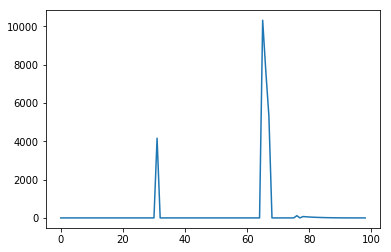

In [200]:
sig_u = 0.5
C_list = [
    B@[
        [sig_u, 0],
        [0, sig_u]
    ],
    B@[
        [0, sig_u],
        [-sig_u, 0]
    ]
]
L_list = backward_recursion_SDN(A,B,C_list,R,Q_list)
L_eigs = []
for L in L_list:
    L_eigs.append(np.linalg.eig(L.T@L)[0][0])
plt.plot(L_eigs)

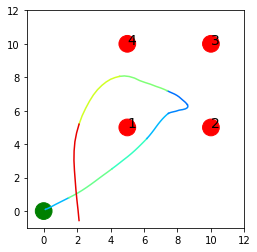

In [195]:
# main loop 
x = np.array([px0, py0, vx0, vy0, fx0, fy0, 1]).reshape(-1,1)
x_list = [x]
u_list = []
for i,t in enumerate(times):
    noise_sum = np.zeros_like(x)
    if i == len(times)-1:
        break
    # compute control
    u = L_list[i]@x
    u_list.append(u)
    # run dynamic
    for C in C_list:
        noise_sum += np.random.normal()*C@u
    x = A@x + B@u + noise_sum
    x_list.append(x.reshape(-1,1))
    
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.axis('square')
lim = 12
ax.set_xlim(-1,lim)
ax.set_ylim(-1,lim)
posx = [x[0] for x in x_list]
posy = [x[1] for x in x_list]
vel_mag = [np.sqrt(x[2]**2+x[3]**2)[0] for x in x_list]

steps=10
c = np.asarray(vel_mag)
c -= np.min(c)
c = c/np.max(c)
it=0
while it<c.size-steps:
    x_segm = posx[it:it+steps+1]
    y_segm = posy[it:it+steps+1]
    c_segm = plt.cm.jet( c[it+steps//2] )
    ax.plot(x_segm, y_segm, c=c_segm)
    it += steps

for i, target in enumerate(targets):
    ax.add_artist(plt.Circle((target[0],target[1]),0.5,color='r'))
    ax.add_artist(plt.Text(target[0],target[1],str(i+1),FontSize=14))
ax.add_artist(plt.Circle((endpoint[0],endpoint[1]),0.5,color='g'))

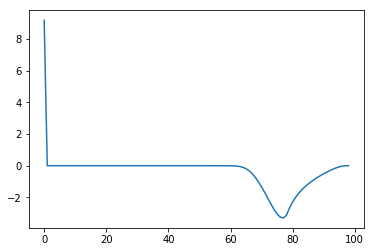

In [181]:
plt.plot([u[0] for u in u_list])